PyImageJ Tutorial
===

This notebook covers how to use ImageJ as a library from Python. A major advantage of this approach is the ability to combine ImageJ with other tools available from the Python software ecosystem, including NumPy, SciPy, scikit-image, CellProfiler, OpenCV, ITK and more.

This notebook assumes familiarity with the ImageJ API. Detailed tutorials in that regard can be found in the other notebooks.

Failed to guess the Java version.


ImageJ version: 2.3.0/1.53f


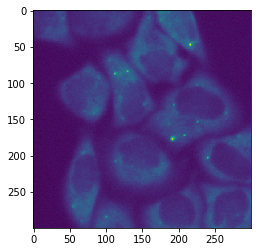

In [1]:
import imagej
import scyjava as sj

# initialize imagej
ij = imagej.init(mode='interactive')
print(f"ImageJ version: {ij.getVersion()}")

dataset = ij.io().open('sample-data/test_still.tif')
ij.py.show(dataset)

In [2]:
# import useful classes
BackgroundSubtracter = sj.jimport('ij.plugin.filter.BackgroundSubtracter')
Dataset = sj.jimport('net.imagej.Dataset')
HyperSphereShape = sj.jimport('net.imglib2.algorithm.neighborhood.HyperSphereShape')
ImagePlus = sj.jimport('ij.ImagePlus')
ImageConverter = sj.jimport('ij.process.ImageConverter')
Overlay = sj.jimport('ij.gui.Overlay')
RoiManager = sj.jimport('ij.plugin.frame.RoiManager')()
ThresholdToSelection = sj.jimport('ij.plugin.filter.ThresholdToSelection')()

# copy the input dataset into a 'working' dataset
processed_dataset = dataset.copy()

# subtract background
bs = BackgroundSubtracter()
imp = ij.convert().convert(processed_dataset, ImagePlus)
ip = imp.getProcessor()
bs.rollingBallBackground(ip, 100.0, False, False, False, False, False)

# convert ImagePlus back to a Dataset
ds_bksb = ij.convert().convert(imp, Dataset)
img_thres = ij.op().threshold().otsu(ds_bksb)

# erode and fill holes
shape = HyperSphereShape(1)
img_erode = ij.op().morphology().erode(img_thres, shape)
img_fill = ij.op().morphology().fillHoles(img_erode)

# HACK: Converter support isn't great yet. Convert back to Dataset then to ImagePlus
ds_fill = ij.dataset().create(img_fill)
imp_fill = ij.convert().convert(ds_fill, ImagePlus)

# create mask from threshold
ic = ImageConverter(imp_fill)
ip = imp_fill.getProcessor()
ip.setThreshold(255, 255, 2)
roi = ThresholdToSelection.convert(ip)

# get ROI manager
ov = Overlay()
rm = RoiManager.getRoiManager()
rm.addRoi(roi)
ov.add(roi)

# convert original Dataset to ImagePlus and display w/ segmentation
original_imp = ij.convert().convert(dataset, ImagePlus)
original_imp.setOverlay(ov)
original_imp.getProcessor().resetMinAndMax()
original_imp.show()
